# 🔷 Natural Gradient Descent — Theory, Intuition, and Visual Experiments

**Goal.** Explore natural gradient descent (NGD) and related curvature-aware methods conceptually and visually.  
We will:

- Build the information-geometry intuition behind NGD.  
- Derive the natural gradient update and link it to Fisher information.  
- Contrast NGD with Newton (Hessian) preconditioning and simple diagonal preconditioning.  
- Implement toy, numerically-stable versions of NGD and curvature-aware updates in 2D and visualize their behavior.  
- Add interactive widgets to tune learning rate, damping, and approximation choices.

**Why this matters.** Natural gradient moves along the steepest descent direction *with respect to the information geometry induced by the model* (the Fisher metric) rather than the Euclidean metric; this often leads to more efficient parameter updates in probabilistic models.

**Key references**
- Amari, S. (1998). *Natural Gradient Works Efficiently in Learning* . 
- Pascanu & Bengio (2013). *Revisiting Natural Gradient for Deep Networks* . 
- Martens & Grosse (2015). *K-FAC: Kronecker-Factored Approximate Curvature* . (practical scalable NGD approximation).
- Martens (2020). *New insights & perspectives on the natural gradient* . 

---

## 💡 Intuition and Mathematical Statement

### Euclidean steepest descent
Gradient descent chooses the direction of steepest descent measured using the **Euclidean metric**:
$$
\theta_{t+1} = \theta_t - \eta \, \nabla_\theta L(\theta_t)
$$

### Natural gradient: steepest descent on the statistical manifold
For a parametric probabilistic model \( p(y \mid x; \theta) \), the parameter space is a Riemannian manifold with metric given by the **Fisher Information Matrix**:
$$
F(\theta) = \mathbb{E}_{x,y \sim p_{\text{data}}} \left[ \nabla_\theta \log p(y\mid x;\theta) \, \nabla_\theta \log p(y\mid x;\theta)^\top \right]
$$

The **natural gradient** is the steepest descent direction under this metric:
$$
\tilde{\nabla}_\theta L(\theta) = F(\theta)^{-1} \, \nabla_\theta L(\theta)
$$
so the update becomes:
$$
\theta_{t+1} = \theta_t - \eta \, F(\theta_t)^{-1} \, \nabla_\theta L(\theta_t)
$$

**Why this helps.** The Fisher captures local sensitivity of the model's predictive distribution to parameter changes — scaling by its inverse normalizes parameter updates relative to how much they change the model output (information). NGD is asymptotically efficient (Amari). 

### Practical difficulty
Computing and inverting the full Fisher is usually intractable for modern neural networks (high dimensional). Practical schemes approximate or factorize the Fisher (diagonal, block-diagonal, Kronecker-factored/K-FAC, low-rank sketches, etc.).

### Step-1: Imports and Environment Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Markdown, clear_output

### Step-2: Define the Sample Function and its Gradient

In [2]:
# A controlled 2D probabilistic-style loss useful for visualization:
# We'll simulate a negative log-likelihood of a Gaussian with mean parameterized by theta=(x,y)
# and fixed variance; equivalently we can visualize a non-convex deterministic loss.
def f(x, y):
    # Rosenbrock-like base to give anisotropy + an additional ridge
    base = (1 - x) ** 2 + 50 * (y - x**2) ** 2
    ripple = 0.2 * np.sin(3.0 * x) * np.cos(2.0 * y)
    return base + ripple

def grad_f(x, y):
    # analytical gradient for the chosen f (computed by symbolic derivation)
    dfdx = -2 * (1 - x) - 200 * x * (y - x**2) + 0.6 * np.cos(3.0 * x) * np.cos(2.0 * y)
    dfdy = 100 * (y - x**2) - 0.4 * np.sin(3.0 * x) * np.sin(2.0 * y)
    return np.array([dfdx, dfdy])

### Step-3: Mesh for Visualization

In [3]:
xs = np.linspace(-1.5, 1.8, 300)
ys = np.linspace(-0.5, 2.5, 300)
X, Y = np.meshgrid(xs, ys)
Z = f(X, Y)

### Step-4: Loss Surface for Visualization

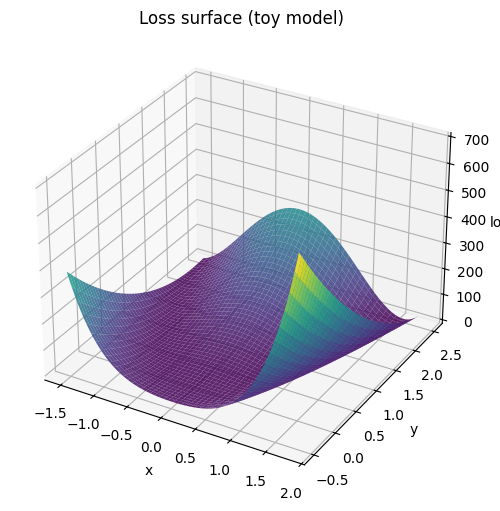

In [4]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.85, linewidth=0, antialiased=True)
ax.set_title("Loss surface (toy model)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("loss")
plt.show()

### Step-5: Geometric Diagnostic: Hessian EignVectors

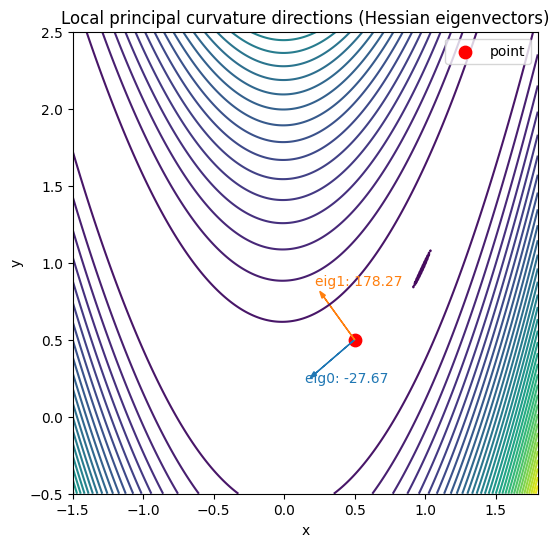

In [6]:
# Numerical Hessian for 2D (central differences)
def hessian_2d(f, x, y, h=1e-4):
    fxx = (f(x+h, y) - 2*f(x, y) + f(x-h, y)) / (h*h)
    fyy = (f(x, y+h) - 2*f(x, y) + f(x, y-h)) / (h*h)
    fxy = (f(x+h, y+h) - f(x+h, y-h) - f(x-h, y+h) + f(x-h, y-h)) / (4*h*h)
    return np.array([[fxx, fxy],[fxy, fyy]])

# pick a point and compute Hessian eigenvectors to visualize principal curvature
pt = np.array([0.5, 0.5])
H = hessian_2d(f, pt[0], pt[1])
eigvals, eigvecs = np.linalg.eigh(H)

plt.figure(figsize=(6,6))
plt.contour(X, Y, Z, levels=40, cmap='viridis')
plt.scatter(pt[0], pt[1], c='red', s=80, label='point')
for i in range(2):
    v = eigvecs[:, i]
    scale = 0.4
    plt.arrow(pt[0], pt[1], scale * v[0], scale * v[1], head_width=0.03, color='C'+str(i), length_includes_head=True)
    plt.text(pt[0] + 0.45*v[0], pt[1] + 0.45*v[1], f'eig{i}: {eigvals[i]:.2f}', color='C'+str(i))
plt.title("Local principal curvature directions (Hessian eigenvectors)")
plt.xlabel("x"); plt.ylabel("y"); plt.legend()
plt.show()

## 🧭 From Hessian to Fisher — what's the metric?

- For *probabilistic models* the appropriate metric is the **Fisher information matrix**:
  $$
  F(\theta) = \mathbb{E} \left[ \nabla_\theta \log p(y|x;\theta) \nabla_\theta \log p(y|x;\theta)^\top \right]
  $$
  which measures parameter sensitivity of the predictive distribution.

- For deterministic losses (e.g., a plain objective $L(\theta)$, one common curvature matrix is the **Hessian** $ H(\theta) = \nabla^2 L(\theta)$. Newton's method uses $H^{-1} \nabla L$. Although Newton and natural gradient are distinct (Fisher vs Hessian), both are **preconditioned** gradients that incorporate curvature information.

- **Approximations**:
  - Diagonal Fisher / Hessian (cheap, often useful)  
  - Low-rank or Kronecker-factored (K-FAC) approximations for neural networks (practical scalable NGD approximations). 


### Step-6: Optmizer Implementation

In [7]:
# Basic optimizers for 2D to compare:
# - SGD (vanilla)
# - Diagonal preconditioning (1/diag(H)+damp)
# - Full Hessian inverse (Newton-like with damping)
# - "Natural gradient" via empirical Fisher (we'll form an empirical Fisher using multiple perturbed gradients)

def sgd_step(x, grad, lr):
    return x - lr * grad

def diag_precondition_step(x, grad, H_diag, lr, damp):
    pre = 1.0 / (H_diag + damp)
    return x - lr * pre * grad

def newton_step(x, grad, H, lr, damp):
    # damp for numerical stability (Levenberg-Marquardt style)
    H_damped = H + damp * np.eye(H.shape[0])
    try:
        delta = np.linalg.solve(H_damped, grad)
    except np.linalg.LinAlgError:
        delta = np.linalg.lstsq(H_damped, grad, rcond=None)[0]
    return x - lr * delta

def empirical_fisher(grad_fn, x, y_grid=None, n_samples=20, eps=1e-3):
    # form an empirical Fisher by sampling nearby pseudo-observations:
    # for a toy deterministic loss, we simulate local variability by perturbing x slightly.
    # This is just for visualization — in real probabilistic models we use gradients of log-likelihoods.
    g_list = []
    for i in range(n_samples):
        noise = eps * np.random.randn(*x.shape)
        g = grad_fn(x[0] + noise[0], x[1] + noise[1])
        g_list.append(g)
    G = np.stack(g_list, axis=1)
    F = G.dot(G.T) / n_samples
    return F

### Step-7: Running Simulations

In [8]:
def run_optimizers(start, lr=0.1, n_iter=80, damp=1e-3, method='sgd'):
    x = start.astype(float).copy()
    path = [x.copy()]
    losses = [f(x[0], x[1])]
    for t in range(n_iter):
        g = grad_f(x[0], x[1])
        if method == 'sgd':
            x = sgd_step(x, g, lr)
        elif method == 'diag':
            # numeric Hessian diagonal
            H = hessian_2d(f, x[0], x[1])
            H_diag = np.diag(H)
            x = diag_precondition_step(x, g, H_diag, lr, damp)
        elif method == 'newton':
            H = hessian_2d(f, x[0], x[1])
            x = newton_step(x, g, H, lr, damp)
        elif method == 'empirical_fisher':
            F = empirical_fisher(grad_f, x, n_samples=40, eps=1e-3)
            F_damped = F + damp * np.eye(F.shape[0])
            try:
                invF = np.linalg.inv(F_damped)
            except np.linalg.LinAlgError:
                invF = np.linalg.pinv(F_damped)
            x = x - lr * invF.dot(g)
        else:
            raise ValueError("Unknown method")
        path.append(x.copy())
        losses.append(f(x[0], x[1]))
    return np.array(path), np.array(losses)

### Step-8: Visualizing the Optimizer Performance

/tmp/ipykernel_10140/50643074.py:6: RuntimeWarning: overflow encountered in scalar power
  base = (1 - x) ** 2 + 50 * (y - x**2) ** 2
/tmp/ipykernel_10140/50643074.py:12: RuntimeWarning: overflow encountered in scalar power
  dfdx = -2 * (1 - x) - 200 * x * (y - x**2) + 0.6 * np.cos(3.0 * x) * np.cos(2.0 * y)
/tmp/ipykernel_10140/50643074.py:13: RuntimeWarning: overflow encountered in scalar power
  dfdy = 100 * (y - x**2) - 0.4 * np.sin(3.0 * x) * np.sin(2.0 * y)
/tmp/ipykernel_10140/50643074.py:6: RuntimeWarning: invalid value encountered in scalar subtract
  base = (1 - x) ** 2 + 50 * (y - x**2) ** 2
/tmp/ipykernel_10140/50643074.py:7: RuntimeWarning: invalid value encountered in sin
  ripple = 0.2 * np.sin(3.0 * x) * np.cos(2.0 * y)
/tmp/ipykernel_10140/50643074.py:7: RuntimeWarning: invalid value encountered in cos
  ripple = 0.2 * np.sin(3.0 * x) * np.cos(2.0 * y)
/tmp/ipykernel_10140/50643074.py:12: RuntimeWarning: invalid value encountered in scalar subtract
  dfdx = -2 * (1 - 

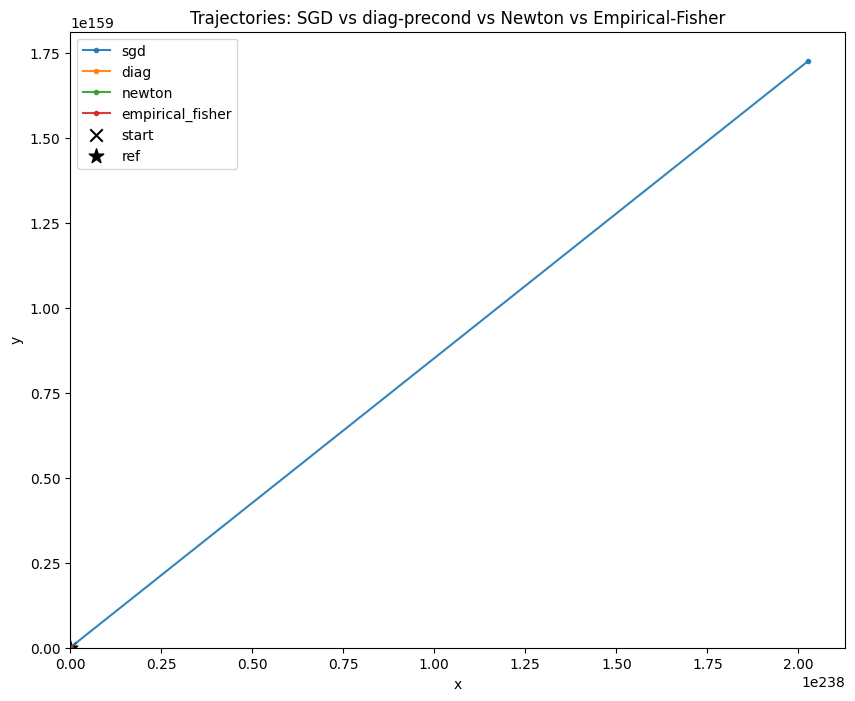

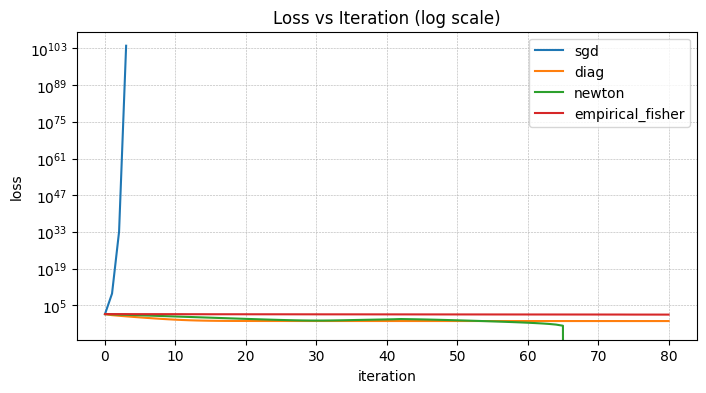

In [9]:
start = np.array([0.9, 1.8])
methods = ['sgd', 'diag', 'newton', 'empirical_fisher']
paths = {}
losses = {}

for m in methods:
    p, l = run_optimizers(start, lr=0.5 if m=='sgd' else 0.1, n_iter=80, damp=1e-2, method=m)
    paths[m] = p
    losses[m] = l

plt.figure(figsize=(10,8))
plt.contour(X, Y, Z, levels=40, cmap='viridis')
for m, p in paths.items():
    plt.plot(p[:,0], p[:,1], '-o', label=m, markersize=3, alpha=0.9)
plt.scatter(start[0], start[1], c='black', marker='x', s=80, label='start')
plt.scatter(1, 1, c='k', marker='*', s=120, label='ref')
plt.title("Trajectories: SGD vs diag-precond vs Newton vs Empirical-Fisher")
plt.xlabel("x"); plt.ylabel("y"); plt.legend()
plt.show()

plt.figure(figsize=(8,4))
for m, l in losses.items():
    plt.plot(l, label=m)
plt.yscale('log')
plt.title("Loss vs Iteration (log scale)")
plt.xlabel("iteration"); plt.ylabel("loss")
plt.legend(); plt.grid(ls='--', lw=0.4)
plt.show()

## 🔎 Interpretation of the visual results

- **SGD** (Euclidean metric) moves in the steepest Euclidean descent direction — this can be inefficient when parameter directions have very different sensitivities (ill-conditioning).  
- **Diagonal preconditioning** rescales updates by $ 1 / \text{diag}(H)$ to adapt per-parameter step sizes; cheap and often effective.  
- **Newton (full Hessian inverse)** uses true second-order curvature and typically makes very rapid progress when the Hessian is well-estimated — but each step may be expensive and sensitive to non-convexity; damping stabilizes inversion.  
- **Empirical Fisher (NGD-like)** attempts to use the Fisher information as a preconditioner; in practice, forming a full Fisher is costly and often approximations (diagonal, block, Kronecker) are used. 

The toy experiments illustrate **faster alignment with narrow directions** for the curvature-aware methods compared to vanilla SGD.

In [10]:
# Interactive visualization: choose method, lr, damping. Requires ipywidgets.
try:
    import ipywidgets as widgets
    from ipywidgets import interact, FloatSlider, Dropdown
except ImportError:
    !pip install ipywidgets
    import ipywidgets as widgets
    from ipywidgets import interact, FloatSlider, Dropdown

def interactive_natural_gradient(method='empirical_fisher', lr=0.1, damp=1e-3, n_iter=80):
    clear_output(wait=True)
    display(Markdown(f"### Method: `{method}` — lr={lr:.4f}, damp={damp:.4g}, iterations={n_iter}"))
    p, l = run_optimizers(start=np.array([0.9,1.8]), lr=lr, n_iter=n_iter, damp=damp, method=method)
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.contour(X, Y, Z, levels=40, cmap='viridis')
    plt.plot(p[:,0], p[:,1], '-o', markersize=4, label=method)
    plt.scatter(1,1,marker='*',s=120,c='k')
    plt.title("Trajectory on contour")
    plt.xlabel("x"); plt.ylabel("y"); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(l, label=f'{method}')
    plt.yscale('log')
    plt.title("Loss vs iteration (log)")
    plt.xlabel("iteration"); plt.ylabel("loss"); plt.legend(); plt.grid(ls='--', lw=0.4)
    plt.show()

interact(
    interactive_natural_gradient,
    method=Dropdown(options=['sgd','diag','newton','empirical_fisher'], value='empirical_fisher', description='method'),
    lr=FloatSlider(value=0.1, min=0.001, max=1.0, step=0.001, description='lr'),
    damp=FloatSlider(value=1e-2, min=1e-6, max=1e-1, step=1e-6, description='damp'),
    n_iter=widgets.IntSlider(value=80, min=10, max=500, step=10, description='n_iter')
)

interactive(children=(Dropdown(description='method', index=3, options=('sgd', 'diag', 'newton', 'empirical_fis…

<function __main__.interactive_natural_gradient(method='empirical_fisher', lr=0.1, damp=0.001, n_iter=80)>

In [ ]:
# Show how preconditioning changes local descent directions at a grid of points:
def preconditioned_vector_field(method='empirical_fisher', damp=1e-3):
    xs = np.linspace(-1.2, 1.6, 25)
    ys = np.linspace(-0.2, 2.2, 25)
    XS, YS = np.meshgrid(xs, ys)
    VX = np.zeros_like(XS)
    VY = np.zeros_like(YS)
    MAG = np.zeros_like(XS)
    for i in range(XS.shape[0]):
        for j in range(XS.shape[1]):
            pt = np.array([XS[i,j], YS[i,j]])
            g = grad_f(pt[0], pt[1])
            if method == 'sgd':
                v = -g
            elif method == 'diag':
                H = hessian_2d(f, pt[0], pt[1])
                pre = 1.0 / (np.diag(H) + damp)
                v = - pre * g
            elif method == 'newton':
                H = hessian_2d(f, pt[0], pt[1])
                H_d = H + damp * np.eye(2)
                try:
                    invH = np.linalg.inv(H_d)
                except np.linalg.LinAlgError:
                    invH = np.linalg.pinv(H_d)
                v = - invH.dot(g)
            elif method == 'empirical_fisher':
                F = empirical_fisher(grad_f, pt, n_samples=30, eps=1e-3)
                F_d = F + damp * np.eye(2)
                try:
                    invF = np.linalg.inv(F_d)
                except np.linalg.LinAlgError:
                    invF = np.linalg.pinv(F_d)
                v = - invF.dot(g)
            norm = np.linalg.norm(v) + 1e-12
            VX[i,j] = v[0]/norm
            VY[i,j] = v[1]/norm
            MAG[i,j] = norm
    plt.figure(figsize=(8,7))
    plt.contour(X, Y, Z, levels=40, cmap='viridis')
    plt.quiver(XS, YS, VX, VY, MAG, cmap='plasma', headwidth=3)
    plt.title(f"Preconditioned descent directions ({method}), color ~ magnitude")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()

# small interactive helper
interact(preconditioned_vector_field, method=Dropdown(options=['sgd','diag','newton','empirical_fisher'], value='empirical_fisher', description='method'),
         damp=FloatSlider(value=1e-2, min=1e-6, max=1e-1, step=1e-6, description='damp'))

interactive(children=(Dropdown(description='method', index=3, options=('sgd', 'diag', 'newton', 'empirical_fis…

<function __main__.preconditioned_vector_field(method='empirical_fisher', damp=0.001)>

## 🧾 Practical notes and scaling to neural networks

- **Full Fisher/Hessian inversion** is feasible for small parameter vectors (toy models); for neural networks we use approximations:
  - **Diagonal approximations** — cheap, often included in optimizers (RMSProp/Adam scale updates by moving averages of squared gradients).  
  - **Block-diagonal / unit-wise** — treat each neuron or layer separately. 
  - **Kronecker-factored approximations (K-FAC)** — factor layerwise blocks as Kronecker products yielding cheap inversion and good empirical results. K-FAC is one of the most practical large-scale NGD approximations. 

- **Damping** (Levenberg-Marquardt style) is critical to stabilize inversion (adds $λI$ to the curvature).  
- **Empirical Fisher vs Fisher vs Hessian**: Empirical Fisher (average of outer products of gradients) can differ from the Hessian, especially for non-log-likelihood losses; understanding their differences matters in practice. 

**Takeaway:** Natural gradient and curvature-aware methods provide principled preconditioning that often yields faster, more robust optimization; the engineering challenge is to compute suitable approximations efficiently for modern networks.

## 🔬 Suggested experiments you can run next

1. **K-FAC shallow network**: implement a small fully-connected network and use a simple K-FAC block for each layer. Compare wall-clock time and epochs to convergence with SGD/Adam.  
2. **Empirical Fisher vs Hessian**: compute both along an optimization trajectory for a small model and visualize their principal directions (eigenvectors).  
3. **Hybrid schedules**: warm-start with Adam then switch to K-FAC / NGD in later training — practitioners have reported improvements in stability and generalization. 

If you want, I can generate a follow-up notebook that:
- implements a **small K-FAC** for a 2-layer MLP in NumPy/PyTorch (layerwise Kronecker factors, invertible damping), and  
- provides an interactive comparison (wall-clock vs iterations) between SGD, Adam, and K-FAC.

## References

- S. Amari, *Natural Gradient Works Efficiently in Learning.* Neural Computation (1998). 
- R. Pascanu & Y. Bengio, *Revisiting Natural Gradient for Deep Networks* (2013). 
- J. Martens & R. Grosse, *Optimizing Neural Networks with Kronecker-factored Approximate Curvature (K-FAC)* (2015).  
- J. Martens, *New insights and perspectives on the natural gradient method* (JMLR, 2020). 